<a href="https://colab.research.google.com/github/davione112/Collection_Preprocessing/blob/master/BikeSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**




In [65]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn import tree

# **Dataset**

In [66]:
url1 = 'https://raw.githubusercontent.com/davione112/work/master/train.csv'
url2 = 'https://raw.githubusercontent.com/davione112/work/master/test.csv'
train = pd.read_csv(url1)
test = pd.read_csv(url2)

- Brief summaries:


In [67]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [68]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [69]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [70]:
#@title Check for missing data
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [71]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [72]:
#@title Combine train and test into a dataset.
dataset = train.append(test)
dataset.reset_index(inplace=True)
dataset.drop('index',inplace=True,axis=1)
dataset = dataset.fillna(0)


In [21]:
dataset.tail(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,0.0,0.0,0.0
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,0.0,0.0,0.0
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,0.0,0.0,0.0


# Understand variables


In [73]:
dataset.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual        float64
registered    float64
count         float64
dtype: object

Text(0.5, 1.0, 'Windspeed')

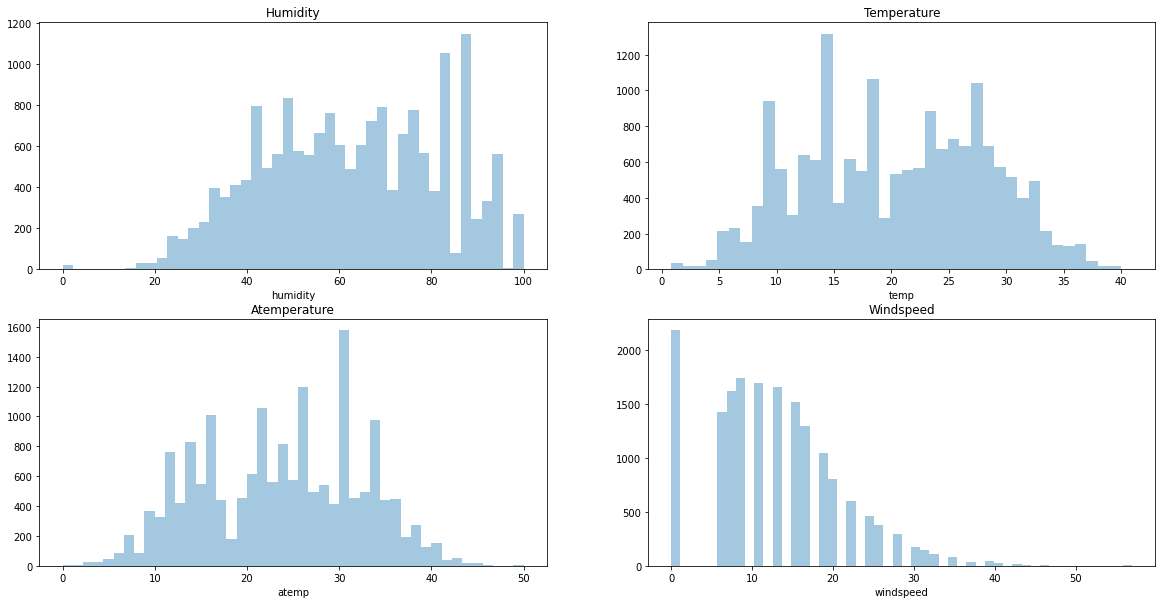

In [74]:
#@title Distributions of continuous variables
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["humidity"],kde=False,ax=ax[0,0])
sb.distplot(dataset["temp"],kde=False,ax=ax[0,1])
sb.distplot(dataset["atemp"],kde=False,ax=ax[1,0])
sb.distplot(dataset["windspeed"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Humidity")
ax[0,1].set_title("Temperature")
ax[1,0].set_title("Atemperature")
ax[1,1].set_title("Windspeed")

- There are so many values = 0 in windspeed.
- Replace those values by median of column "windspeed".

12.736539622533591


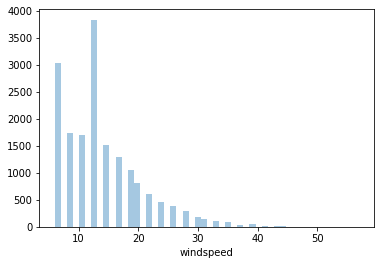

In [75]:
x = dataset['windspeed'].mean()
print(x)
dataset['windspeed'] = dataset['windspeed'].replace(0,x)
sb.distplot(dataset["windspeed"],kde=False)

Text(0.5, 1.0, 'Workingday')

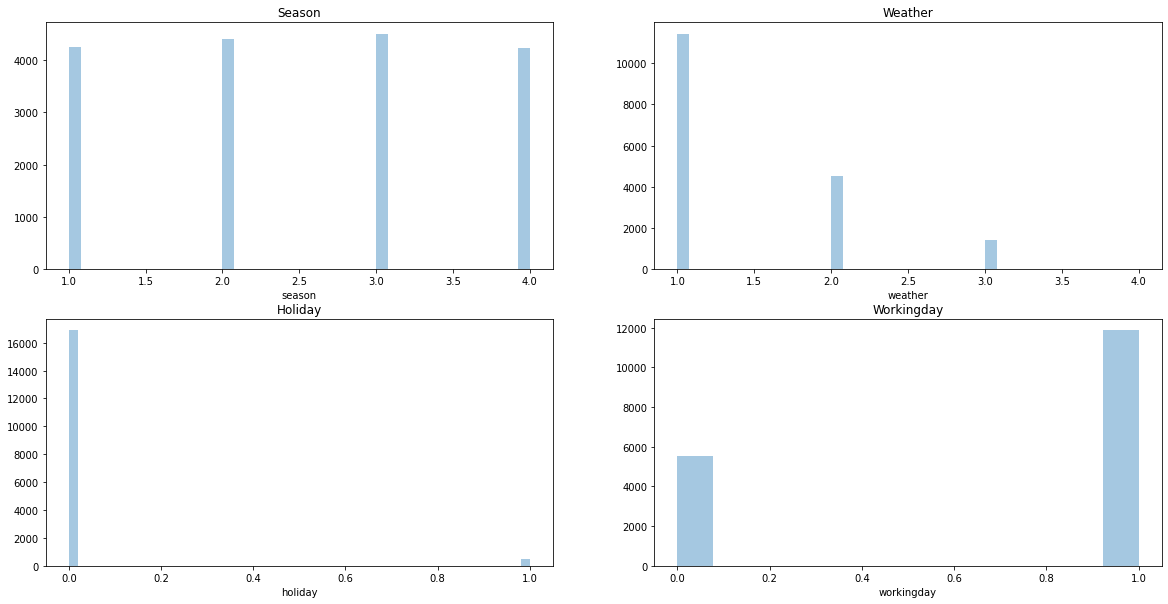

In [76]:
#@title Distributions of categorical variables
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,10)
sb.distplot(dataset["season"],kde=False,ax=ax[0,0])
sb.distplot(dataset["weather"],kde=False,ax=ax[0,1])
sb.distplot(dataset["holiday"],kde=False,ax=ax[1,0])
sb.distplot(dataset["workingday"],kde=False,ax=ax[1,1])

ax[0,0].set_title("Season")
ax[0,1].set_title("Weather")
ax[1,0].set_title("Holiday")
ax[1,1].set_title("Workingday")

In [77]:
#@title Hour trending
# convert 'datetime' column to datetime datatype
dataset['datetime'] = pd.to_datetime(dataset['datetime'],
                                     format='%Y-%m-%d %H:%M:%S')

In [78]:
# add 'hour' and 'date' columns to dataset
hours = []
for i in range(len(dataset['datetime'])):
  hours.append(dataset['datetime'][i].hour)
dataset["hour"] = hours
dates = []
for i in range(len(dataset['datetime'])):
  dates.append(dataset['datetime'][i].day)
dataset["date"] = dates

In [79]:
# divide dataset into train and test
dataset[['season','holiday','weather','workingday']] = dataset[['season','holiday','weather','workingday']].astype('category')
dataset.head(5)
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date']) >=20]

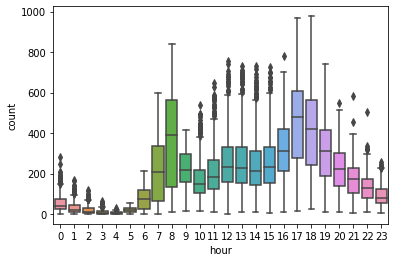

In [80]:
# boxplot bike rentals per hour in train set.
sb.boxplot(x='hour',y='count',data=train)

Text(0.5, 1.0, 'Registered per hour')

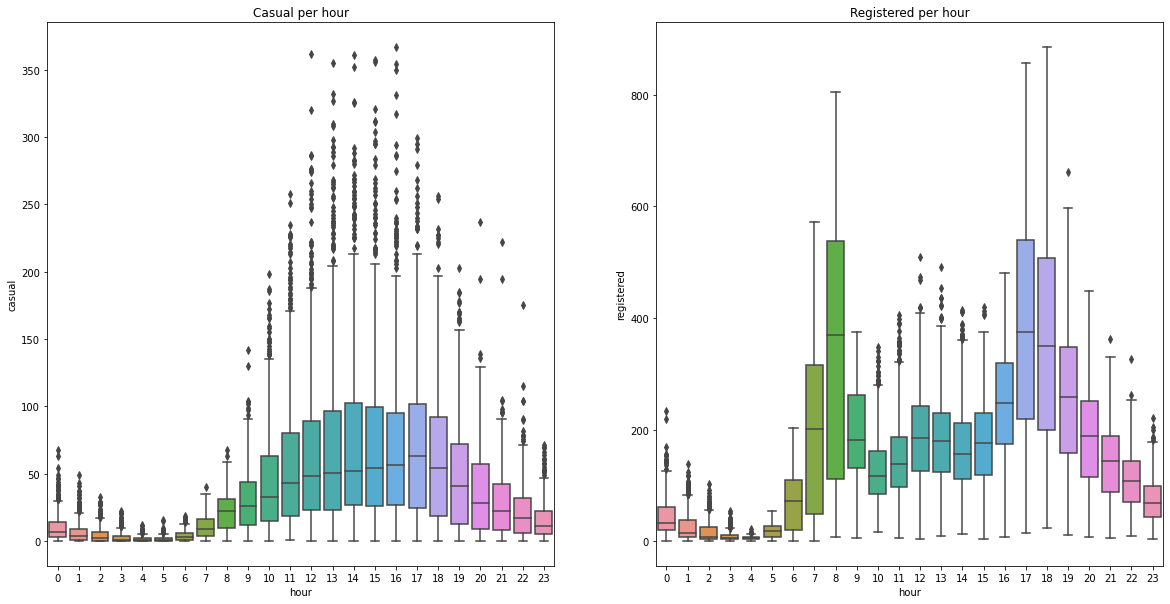

In [81]:
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='hour',y='casual',data=train,ax=axis1)
sb.boxplot(x='hour',y='registered',data=train,ax=axis2)

axis1.set_title('Casual per hour')
axis2.set_title('Registered per hour')

- From those 3 plots, we get some prediction:


1.   High count: 7-9 hour , 16-19 hour.
2.   Average count: 10-15 hour, 20-22 hour.
3.   Low count: 0-6 hour, 23 hour.

=> We can segregate into categories, with code lines below:


In [82]:
dataset['hour'] = dataset['hour'].astype('int64')
#dataset['hour_ctg'] = 0
dataset.loc[(dataset['hour']>=0) & (dataset['hour']<=6),'hour_ctg'] = 1
dataset.loc[(dataset['hour']>=23),'hour_ctg'] = 1
dataset.loc[(dataset['hour']>=7) & (dataset['hour']<=9),'hour_ctg'] = 3
dataset.loc[(dataset['hour']>=16) & (dataset['hour']<=19),'hour_ctg'] = 3
dataset.loc[(dataset['hour']>=10) & (dataset['hour']<=15),'hour_ctg'] = 2
dataset.loc[(dataset['hour']>=20) & (dataset['hour']<=22),'hour_ctg'] = 2

In [83]:
# divide dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date']) >=20]

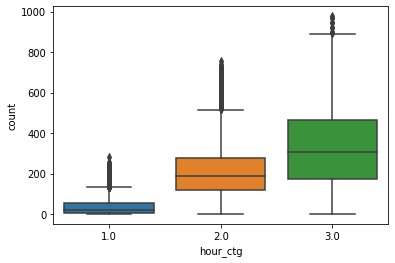

In [84]:
sb.boxplot(x='hour_ctg',y='count',data=train)

In [90]:
#@title Daily trend
# extracting days of week from datetime
days = []
for i in range(len(dataset['datetime'])):
  days.append(dataset['datetime'][i].weekday())
dataset['day'] = days

In [91]:
dataset.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
hour                   int64
date                   int64
hour_ctg             float64
day                    int64
dtype: object

In [92]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

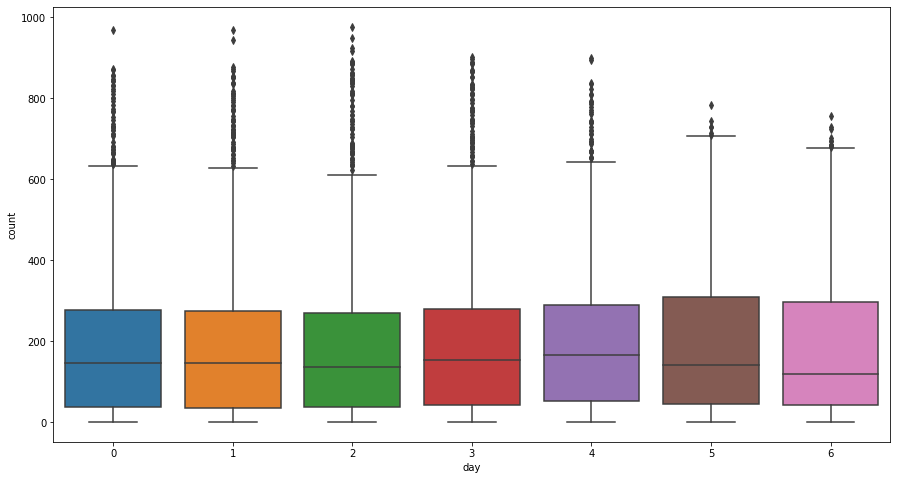

In [97]:
# Boxplot shows users’ demand over days.
plt.figure(figsize=(15,8))
sb.boxplot(x='day',y='count',data=train)

- In this plot: 0-Monday, 1-Tuesday, 2-Wednesday, 3-Thursday, 4-Friday, 5-Saturday, 6-Sunday.

Text(0.5, 1.0, 'Count per workingday')

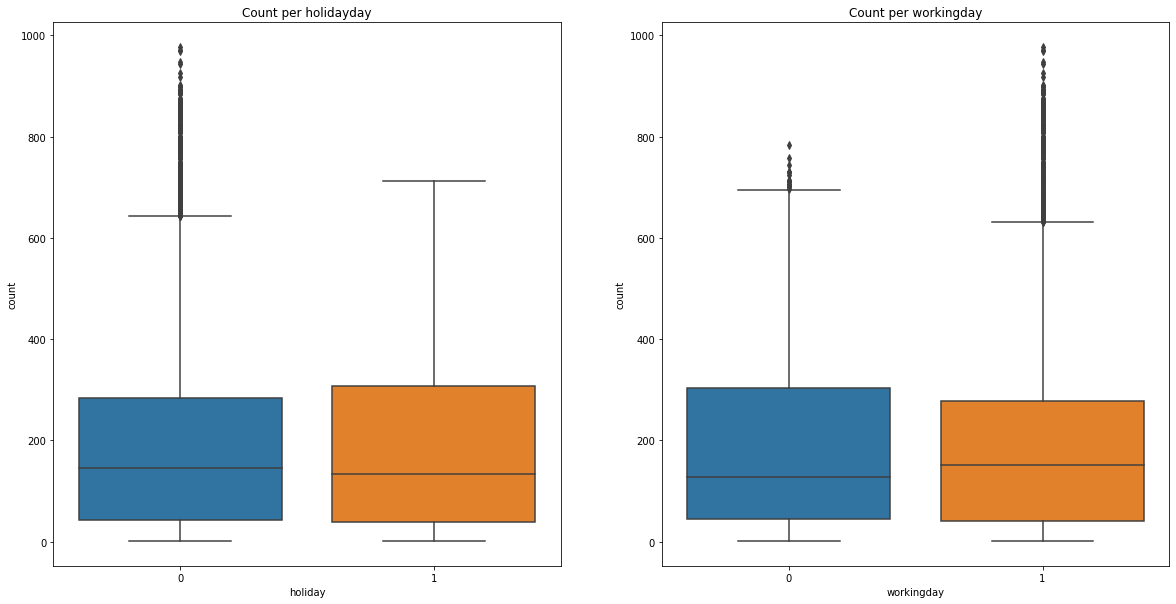

In [98]:
# Boxplot shows users’ demand over holidays.
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='holiday',y='count',data=train, ax=axis1)
sb.boxplot(x='workingday',y='count',data=train,ax=axis2)

axis1.set_title('Count per holidayday')
axis2.set_title('Count per workingday')

- 'holiday' boxplot and 'workingday' boxplot are similar.

Text(0.5, 1.0, 'Registered per weather')

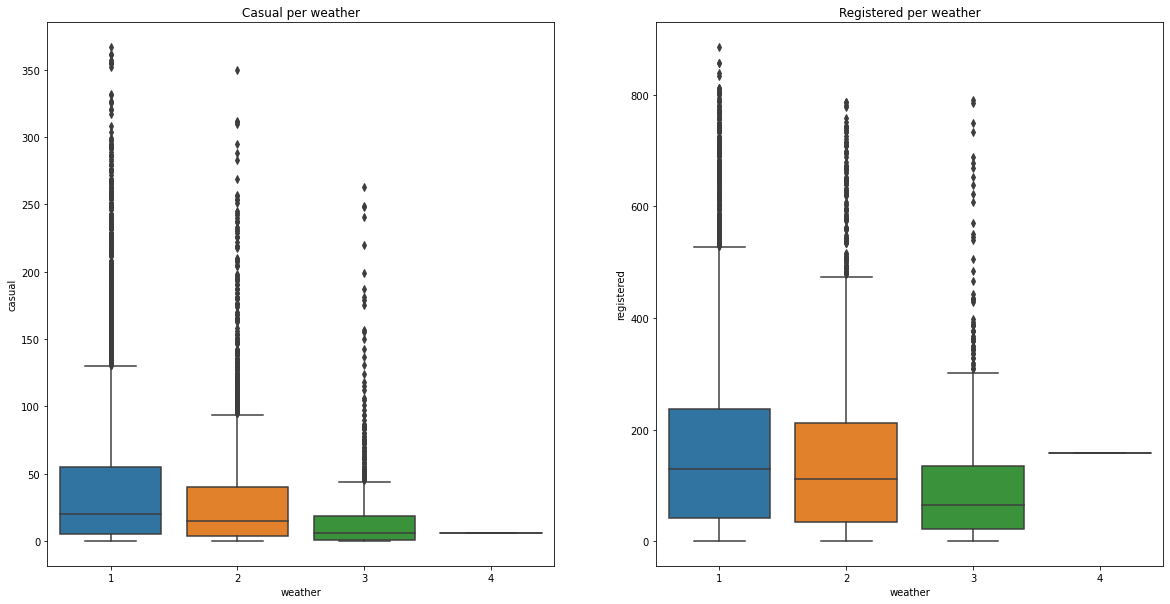

In [ ]:
#@title Weather trending
# Boxplot shows registered and casual users’ demand each weather.
fig, (axis1,axis2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
sb.boxplot(x='weather',y='casual',data=train,ax=axis1)
sb.boxplot(x='weather',y='registered',data=train,ax=axis2)

axis1.set_title('Casual per weather')
axis2.set_title('Registered per weather')

In [105]:
#@title Comparision of bike rentals between 2011 and 2012
# Extract 'year' from datetime.
years = []
for i in range(len(dataset['datetime'])):
  years.append(dataset['datetime'][i].year)
dataset['year'] = years

In [106]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

Text(0.5, 1.0, 'bike rentals between 2011 and 2012')

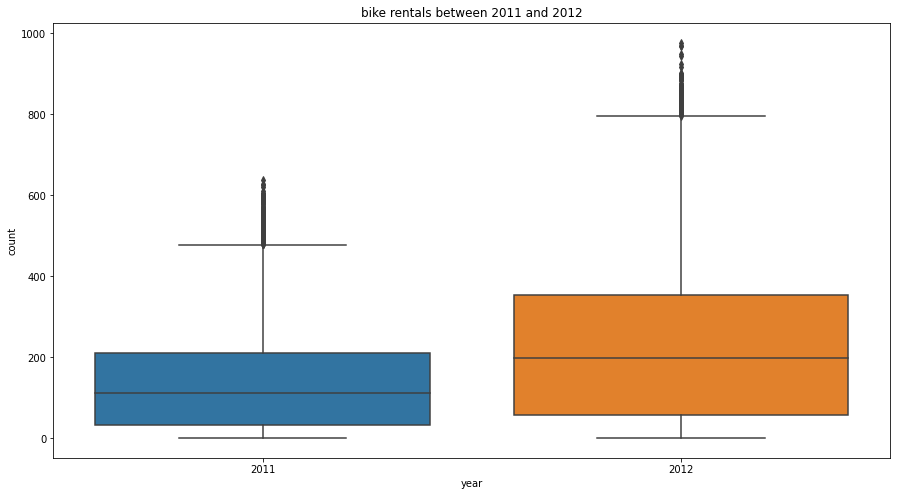

In [107]:
# Boxplot of bike rentals between '2011' and '2012'
plt.figure(figsize=(15,8))
sb.boxplot(x='year',y='count',data=train)
plt.title('bike rentals between 2011 and 2012')

##Season trending

In [110]:
# Combine 'year' and 'season'
dataset['year_season']= dataset['year'] + pd.to_numeric(dataset['season'])/10

In [111]:
# divide again dataset into train and test
train = dataset[pd.to_numeric(dataset['date']) < 20]
test = dataset[pd.to_numeric(dataset['date'])>=20]

Text(0.5, 1.0, 'bike rentals between each seasons in 2011 and 2012')

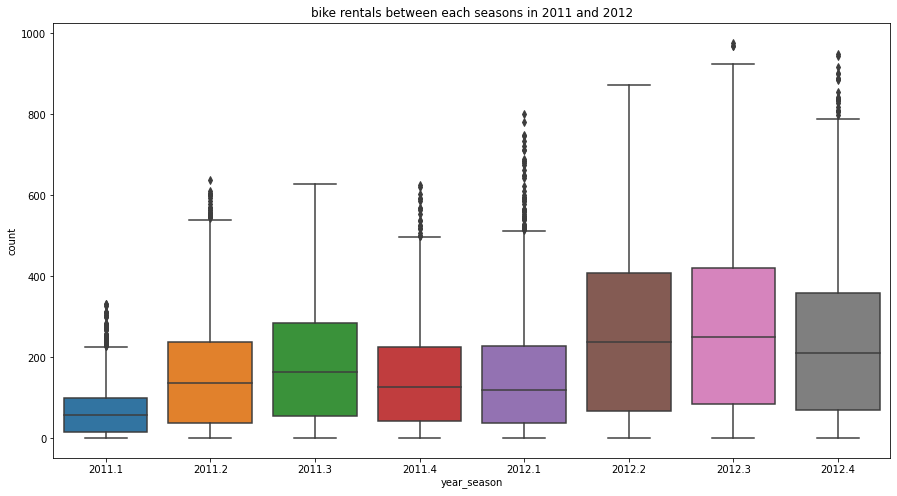

In [112]:
plt.figure(figsize=(15,8))
sb.boxplot(x='year_season',y='count',data=train)
plt.title('bike rentals between each seasons in 2011 and 2012')

Amount of bike rentals in season 1,4 of 2011 and season 1 of 2012 is lower than the others season. 

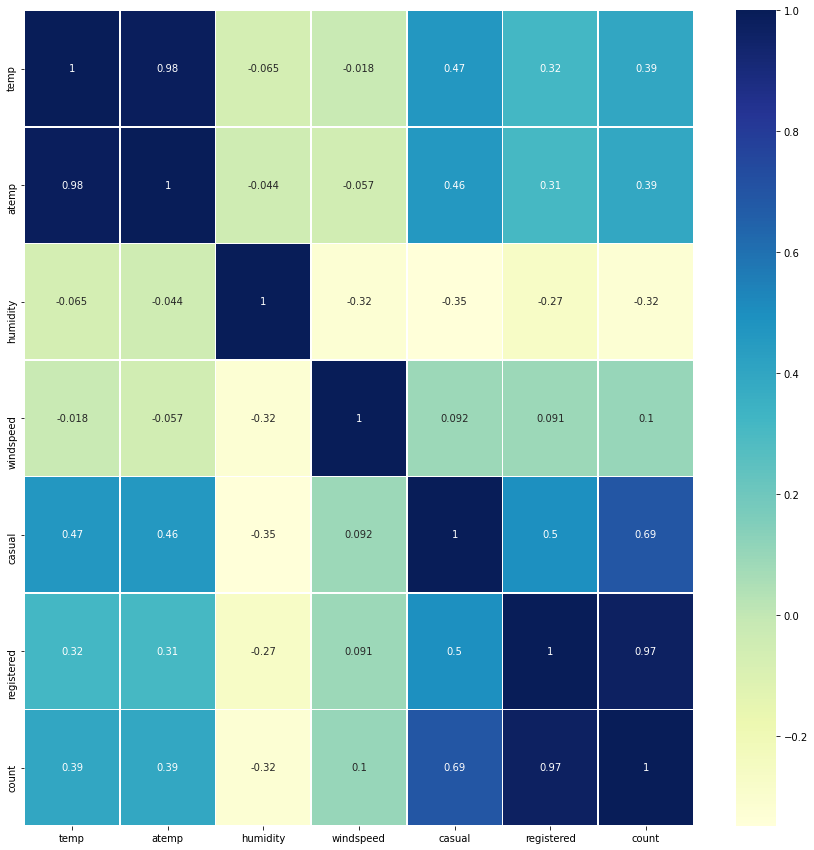

In [ ]:
#@title Correlation matrix of continuous variables
x = train.corr()
plt.figure(figsize=(15,15))
sb.heatmap(x, cmap='YlGnBu', annot=True, annot_kws={"size":10}, linewidths=0.5)

# **Preprocessing**

In [ ]:
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,day,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,0,1,5,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,1,1,5,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2,1,5,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,3,1,5,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,4,1,5,2011


In [ ]:
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,day,year
10886,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0.0,0.0,0.0,0,20,3,2011
10887,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,0.0,0.0,0.0,1,20,3,2011
10888,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,0.0,0.0,0.0,2,20,3,2011
10889,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.0,0.0,0.0,3,20,3,2011
10890,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.0,0.0,0.0,4,20,3,2011


In [ ]:
test.reset_index(drop=True)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,date,day,year
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0.0,0.0,0.0,0,20,3,2011
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,0.0,0.0,0.0,1,20,3,2011
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,0.0,0.0,0.0,2,20,3,2011
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.0,0.0,0.0,3,20,3,2011
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,0.0,0.0,0.0,4,20,3,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0,19,31,0,2012
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,0.0,0.0,0.0,20,31,0,2012
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,0.0,0.0,0.0,21,31,0,2012
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,0.0,0.0,0.0,22,31,0,2012


In [ ]:
train.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
hour                category
date                category
day                 category
year                category
dtype: object